# Premier Modèle GAN

Le premier modèle que nous testons est un [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) avec une pénalité de gradient et un réseau de neurone convolutif. Le principal différence entre un GAN classique et un Wasserstein GAN réside dans la manière dont la fonction de perte est calculée. Le WGAN utilise utilise la distance de Wasserstein pour mesurer la distance entre la distribution réelle et la distribution générée. Cette distance est mieux adaptée pour mesurer la distance entre deux distributions lorsque ces distributions ont des supports de mesure différents. Ce qui permet de remédier à un problème bien connu des GAN, le fait que le générateur génère des données qui sont souvent très similaires (ici, cela entraînerait une faible diversité de scénario générées).

De l'autre côté, les réseaux de neurones convolutifs sont très populaires en Computer Vision. Leur architecture permet de synthétiser l'information présent dans une chaine de valeur (dans le cas d'images, cela représente par exemple des petites parties de l'image) et sont ainsi intéressant lorsque l'on traite de séries temporelles. 
<img src="img/conv_network.png" alt="Texte alternatif" style="width: 800px;">


In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.network import *
from utils.create_data import *
from utils.data import *
from utils.metrics import plot_tsne
import random

On sélectionne un actif de notre jeu de données. Ici c'est "UK Government Bond - USD Hedged".

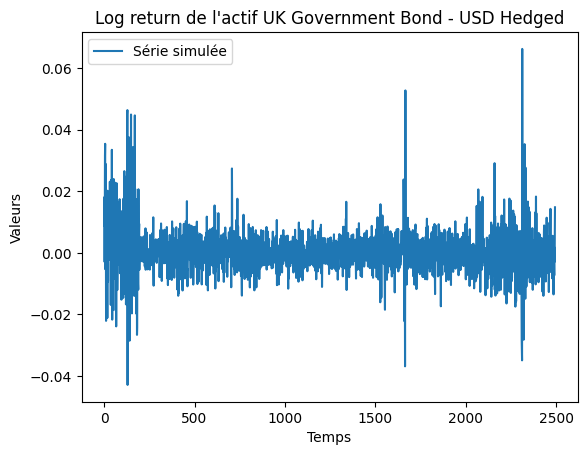

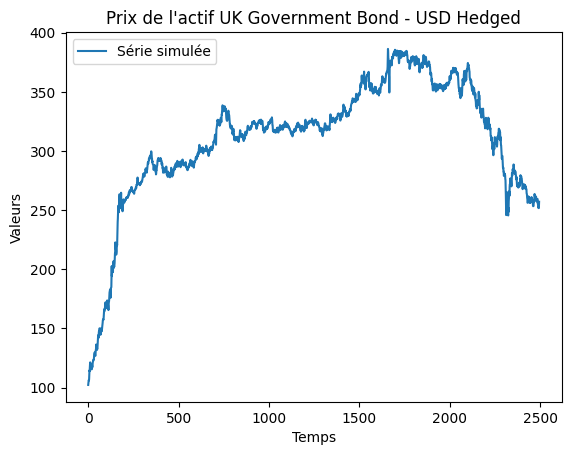

In [2]:
df = pd.read_csv('./data/GANData.csv')
actif = "UK Government Bond - USD Hedged"
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
simple_plot(y[:], f"Log return de l'actif {actif}")
simple_plot(true_y[:], f"Prix de l'actif {actif}")

### Calcul du score du modèle

Pour calculer le "score" du modèle, on génère à l'aide du générateur $k$ scénarios et on calcule la moyenne et la variance de chaque série. On compare ensuite les moyennes et variances des séries générées aux moyennes et variances d'échantillon de la vraie série. On calcule ensuite le score de la manière suivante:

$score = |\tilde{M} - M| + \lambda *|\tilde{V}-V|$

où:

* $\tilde{M}$ est la moyenne calculée sur les scénarios générés
* $ M $ est la moyenne calculée sur les vraies données
* $\tilde{V}$ est la variance calculée sur les scénarios générés
* $ V $ est la variance calculée sur les vraies données
* $\lambda$ est un paramètre pour contrôler l'importance relative qu'on porte sur la moyenne ou la variance (défaut à 1.5)

In [3]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 100
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print(use_cuda)

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=1.5)
train.train_model(epochs=epochs)

True


  0%|          | 0/100 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1283: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  1%|          | 1/100 [00:03<05:55,  3.59s/it]

best score : 0.037401157431304455  epoch : 0


  2%|▏         | 2/100 [00:05<04:37,  2.84s/it]

best score : 0.029031813610345125  epoch : 1


  3%|▎         | 3/100 [00:08<04:15,  2.63s/it]

best score : 0.0211045085452497  epoch : 2


  4%|▍         | 4/100 [00:10<04:02,  2.52s/it]

best score : 0.01548281405121088  epoch : 3


  5%|▌         | 5/100 [00:13<03:54,  2.47s/it]

best score : 0.011853482807055116  epoch : 4


  6%|▌         | 6/100 [00:15<03:50,  2.45s/it]

best score : 0.009065175545401871  epoch : 5


  7%|▋         | 7/100 [00:17<03:43,  2.40s/it]

best score : 0.007039980264380574  epoch : 6


  8%|▊         | 8/100 [00:20<03:37,  2.37s/it]

best score : 0.00566053538932465  epoch : 7


 15%|█▌        | 15/100 [00:35<03:11,  2.25s/it]

best score : 0.005016128299757838  epoch : 14


 16%|█▌        | 16/100 [00:37<03:10,  2.27s/it]

best score : 0.004183783428743482  epoch : 15


 17%|█▋        | 17/100 [00:40<03:10,  2.29s/it]

best score : 0.0034388117492198944  epoch : 16


 18%|█▊        | 18/100 [00:42<03:10,  2.32s/it]

best score : 0.0031459844030905515  epoch : 17


 22%|██▏       | 22/100 [00:51<03:00,  2.31s/it]

best score : 0.0031397028360515833  epoch : 21


 23%|██▎       | 23/100 [00:54<03:01,  2.35s/it]

best score : 0.0030700319912284613  epoch : 22


 24%|██▍       | 24/100 [00:56<03:02,  2.40s/it]

best score : 0.0027803427074104548  epoch : 23


 25%|██▌       | 25/100 [00:58<02:59,  2.40s/it]

best score : 0.00246297538978979  epoch : 24


 26%|██▌       | 26/100 [01:01<02:57,  2.40s/it]

best score : 0.0020839711651206017  epoch : 25


 27%|██▋       | 27/100 [01:03<02:56,  2.42s/it]

best score : 0.001767884095897898  epoch : 26


 28%|██▊       | 28/100 [01:06<02:49,  2.36s/it]

best score : 0.0015101343451533467  epoch : 27


 29%|██▉       | 29/100 [01:08<02:44,  2.32s/it]

best score : 0.0013031177513767034  epoch : 28


 33%|███▎      | 33/100 [01:17<02:35,  2.32s/it]

best score : 0.0012818048417102545  epoch : 32


 34%|███▍      | 34/100 [01:19<02:33,  2.33s/it]

best score : 0.0012077668361598626  epoch : 33


 35%|███▌      | 35/100 [01:22<02:30,  2.32s/it]

best score : 0.0010764983744593337  epoch : 34


 36%|███▌      | 36/100 [01:24<02:28,  2.33s/it]

best score : 0.000999330572085455  epoch : 35


 37%|███▋      | 37/100 [01:26<02:26,  2.32s/it]

best score : 0.0009136565786320716  epoch : 36


 38%|███▊      | 38/100 [01:29<02:24,  2.32s/it]

best score : 0.0008114980882965028  epoch : 37


 44%|████▍     | 44/100 [01:43<02:11,  2.35s/it]

best score : 0.0006769626343157142  epoch : 43


 45%|████▌     | 45/100 [01:45<02:08,  2.33s/it]

best score : 0.000559158535907045  epoch : 44


 55%|█████▌    | 55/100 [02:08<01:45,  2.35s/it]

best score : 0.0003790220434893854  epoch : 54


 60%|██████    | 60/100 [02:20<01:34,  2.36s/it]

best score : 0.0003473374235909432  epoch : 59


 61%|██████    | 61/100 [02:22<01:32,  2.36s/it]

best score : 0.00029937502404209226  epoch : 60


 69%|██████▉   | 69/100 [02:41<01:12,  2.33s/it]

best score : 0.0002601807427708991  epoch : 68


 85%|████████▌ | 85/100 [03:18<00:32,  2.19s/it]

best score : 0.00025604514667065814  epoch : 84


 89%|████████▉ | 89/100 [03:27<00:25,  2.31s/it]

best score : 0.0002413000402157195  epoch : 88


100%|██████████| 100/100 [03:53<00:00,  2.34s/it]


Une fois le modèle entraîné, on peut générer un sous échantillon de données.

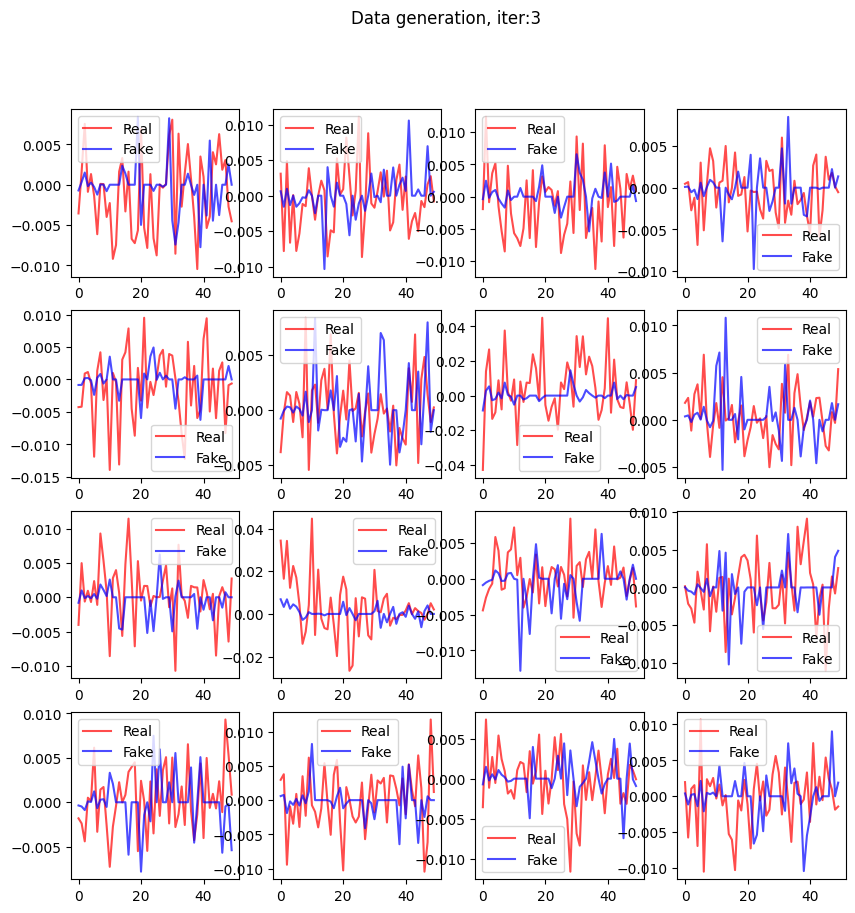

In [4]:
show_examples(train.real_lines, train.fake_lines, size=4)

On peut maintenant générer des faux scénarios à partir des logs returns générés. On prends un point de base $S_t$ et on a:

$\hat{S}_{t+j} = S_t * \prod_{i=1}^{j} (1+\hat{r}_i)$

où $\hat{r}_i$ est le i-ème log return généré 

In [ ]:
from utils.network import generate_fake_scenario, evaluate_fake_scenario

In [137]:
# Exemple d'utilisation de np.partition pour trouver la k-ème plus petite valeur
arr = np.array([[5, 2, 8, 1, 6, 9, 3, 7, 4],[5, 2, 8, 0, 6, 9, 3, 7, 4]])
k = 3  # Recherche de la 3ème plus petite valeur
kth_smallest = np.partition(arr, k-1)[k-1]
print(f"La {k}-ème plus petite valeur dans le tableau est : {kth_smallest}")

IndexError: index 2 is out of bounds for axis 0 with size 2

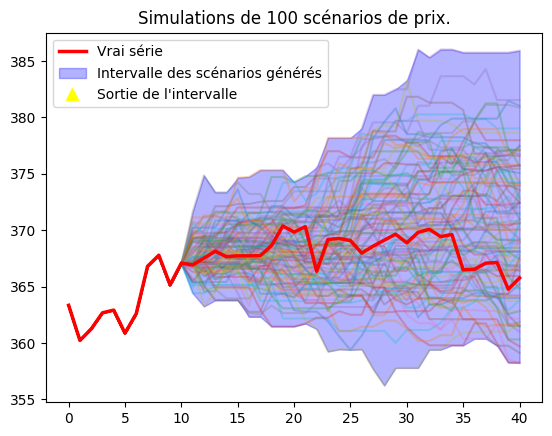

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 0 
 --------------------------------------------------


In [172]:
start = 2000


x= generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =100)

In [145]:
x
np.partition(x, 1, axis=0)[1]

array([360.21816724, 361.22824108, 362.66003807, 362.89915096,
       360.84961499, 362.58818076, 366.75053392, 367.73046147,
       365.09707943, 367.02436268, 366.183212  , 366.10875587,
       363.80984168, 364.33943742, 364.63371022, 364.08094168,
       364.03368651, 363.70238056, 361.28060726, 360.86659393,
       358.7296294 , 361.38936778, 361.60351036, 361.60351036,
       363.85337187, 363.85337187, 362.97414851, 361.60788504,
       361.76065221, 361.76065221, 362.73683313, 361.73643989,
       361.57804195, 363.79013397, 363.79013397, 361.74126936,
       360.8593389 , 359.94232439, 359.94232439, 359.1073459 ])

10


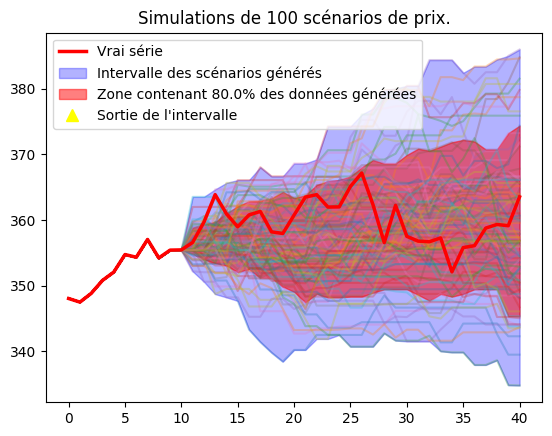

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 0 
 --------------------------------------------------


array([[347.51089725, 348.8412939 , 350.80713916, ..., 354.23138361,
        353.54469248, 353.54469248],
       [347.51089725, 348.8412939 , 350.80713916, ..., 378.68580329,
        378.68580329, 378.68580329],
       [347.51089725, 348.8412939 , 350.80713916, ..., 363.042025  ,
        363.042025  , 363.75016745],
       ...,
       [347.51089725, 348.8412939 , 350.80713916, ..., 359.76715143,
        359.76715143, 359.76715143],
       [347.51089725, 348.8412939 , 350.80713916, ..., 349.47948098,
        346.10504757, 346.10504757],
       [347.51089725, 348.8412939 , 350.80713916, ..., 370.67035438,
        365.18848456, 362.94393813]])

In [190]:
start = 1500

generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =100, reducer=3,j=0.8)

1726


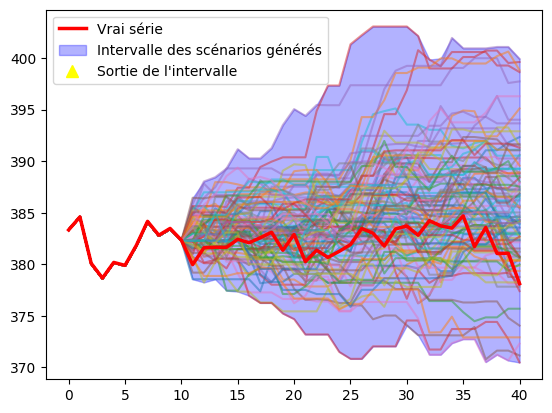

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 0 
 --------------------------------------------------


In [117]:
start = random.randint(0, 2000)
print(start)
generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num = 100,reducer=5)

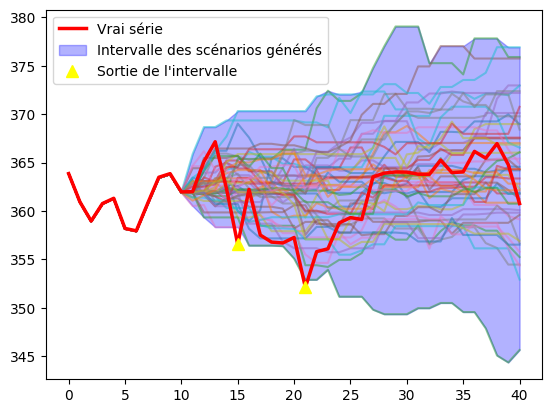

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 2 
 --------------------------------------------------


In [108]:
start = random.randint(0, 2000)
# On part d'un point aléatoire de la série
generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =50)

Maintenant, on génère 10 scénarios, et sur 500 simulations, on regarde combien de données en moyenne se sont trouvé en dehors de l'intervalle des faux scénarios.

In [18]:
evaluate_fake_scenario(y[200:],true_y[200:],train, amplifier = 1,num = 10,reducer=4, n=500)

---------------------------------------------------------------------------------------------------- 
Moyenne du nombre de fois que la vraie série est sortie de l'intervalle sur 500 simulations pour 10 scénarios simulés :
 2.552 
 ----------------------------------------------------------------------------------------------------


2.552

On regarde maintenant le nombre moyen de données en dehors de l'intervalle lorsque l'on augmente le nombre de scénarios générés.

In [88]:
list_val=[]
for k in trange(100):
    list_val.append(evaluate_fake_scenario(y[200:],true_y[200:],train, amplifier = 1,num = k+2,reducer=4, n=200, no_print=True))

100%|██████████| 100/100 [11:16<00:00,  6.77s/it]


Text(0.5, 1.0, 'Moyenne du nombre de valeures prédites en dehors des données générées pour k scénarios générés avec k allant de 2 à 102 ')

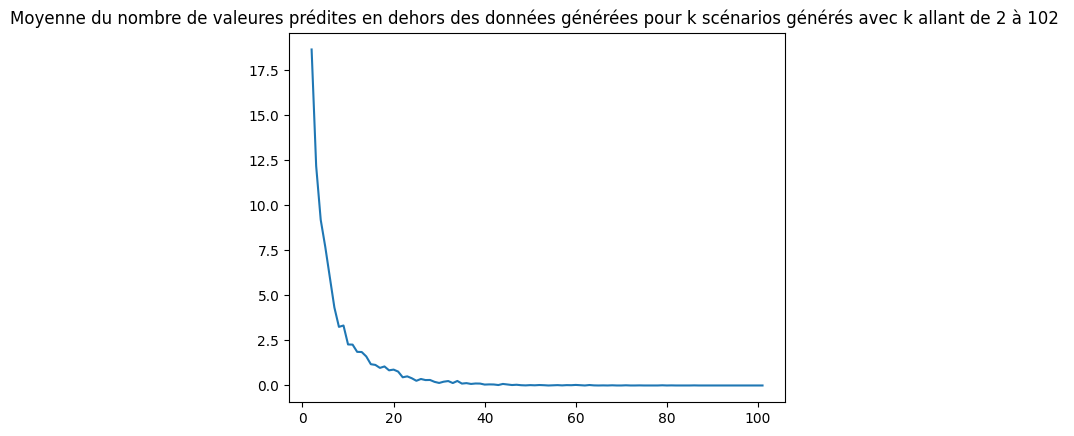

In [89]:
indices = range(2, len(list_val) + 2)

plt.plot(indices, list_val)
plt.title(f"Moyenne du nombre de valeures prédites en dehors des données générées pour k scénarios générés avec k allant de 2 à {len(list_val) + 2} ")
plt.show()

En augmentant le nombre de scénarios, on obtient peu de données en dehors de l'intervalle (ce qui est logique) mais les intervalles deviennent très grandes.

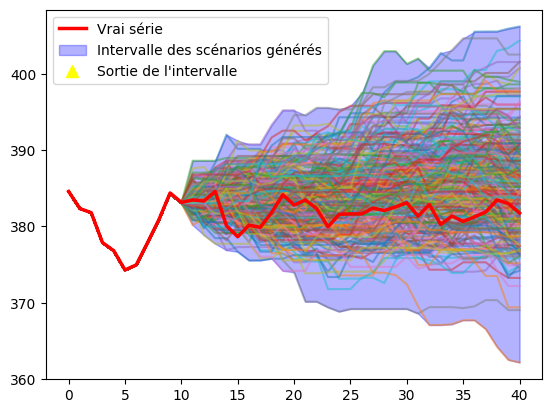

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 0 
 --------------------------------------------------


In [122]:
start = random.randint(0, 2000)
generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =300)

Une autre manière d'étudier la vraisemblance de nos données est d'appliquer un algorithme de réduction de dimension, et observer si les vraies données et les données générées semblent proches. L'approche est visuelle, il faut donc prendre les résultats avec des pincettes.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.012839
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.296066
[t-SNE] KL divergence after 300 iterations: 1.416325


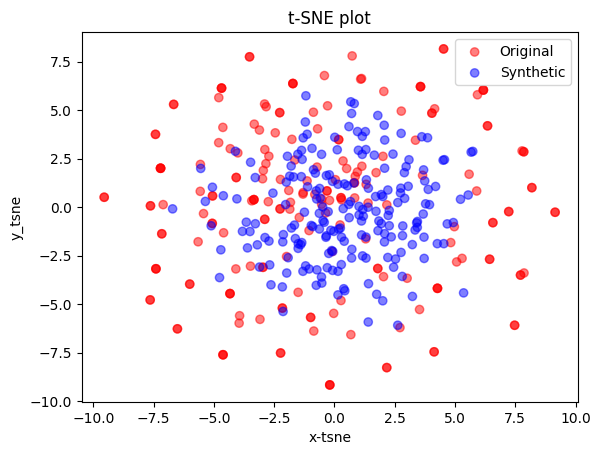

In [99]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=200, conditional= train.conditional, use_cuda=True, data = train.data)
fake = fake/3
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=False)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 420 samples in 0.000s...
[t-SNE] Computed neighbors for 420 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 420 / 420
[t-SNE] Mean sigma: 0.013156
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.326279
[t-SNE] KL divergence after 300 iterations: 1.400427


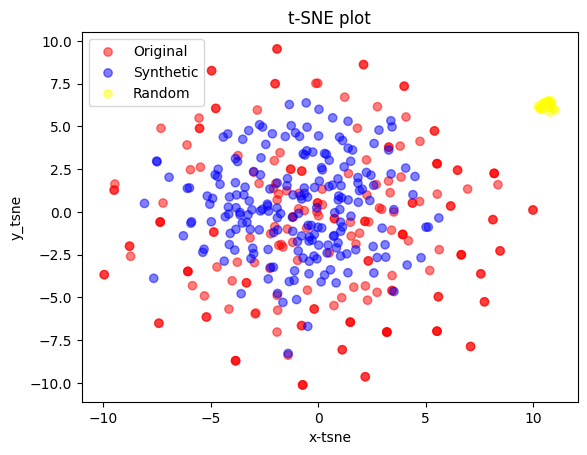

In [101]:
plot_tsne(real_array,fake_array, random=True)

In [102]:
from utils.metrics import plot_var, plot_mean

100%|██████████| 10000/10000 [02:27<00:00, 67.76it/s]


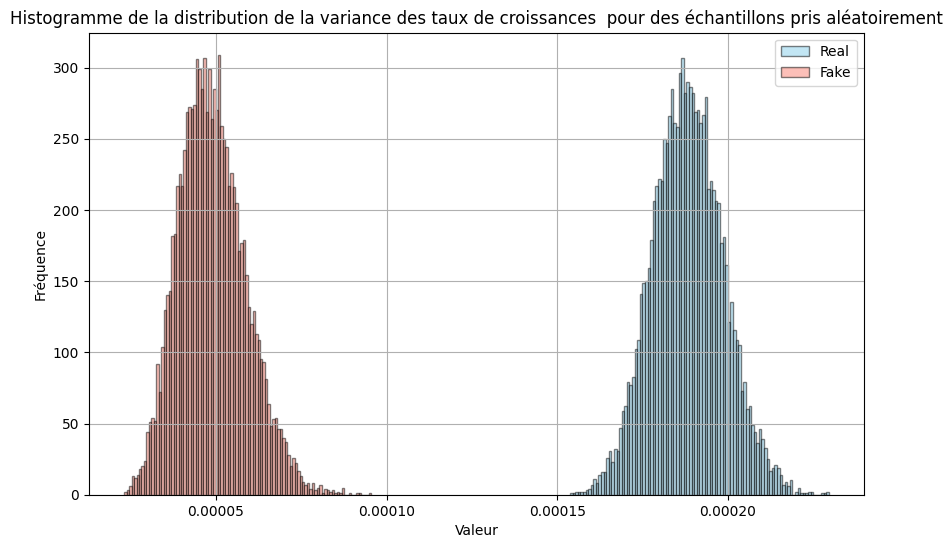

100%|██████████| 10000/10000 [02:06<00:00, 79.01it/s]


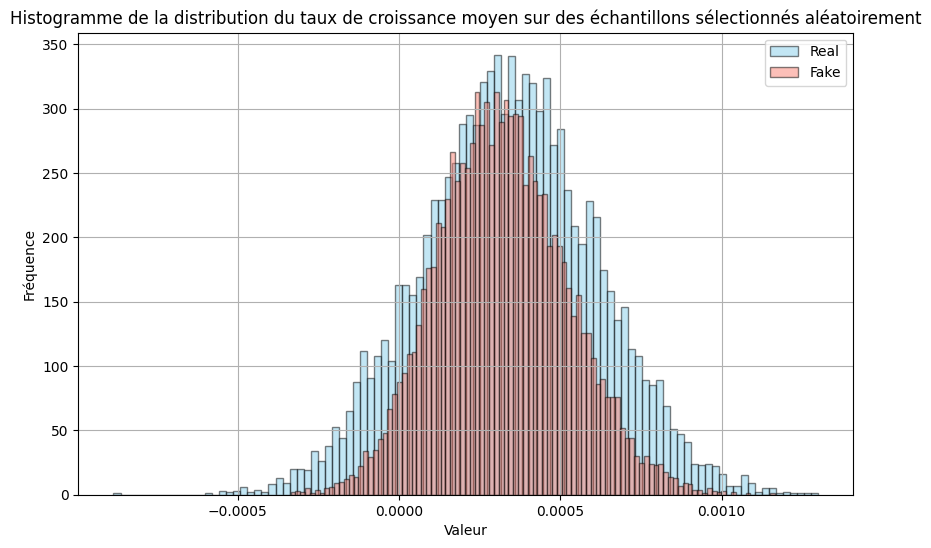

In [103]:
plot_var(train)
plot_mean(train)

# Amérlioration du Modèle

## Entrainement sur plusieurs séries temp

Dans un premier lieu on fixe cond à 0 et on relance l'entrainement

In [ ]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 2000
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda)
train.train_model(epochs=epochs)

True


  0%|          | 0/2000 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1283: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 2000/2000 [25:02<00:00,  1.33it/s]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Une fois le modèle entraîné, on peut générer un sous échantillon de données.

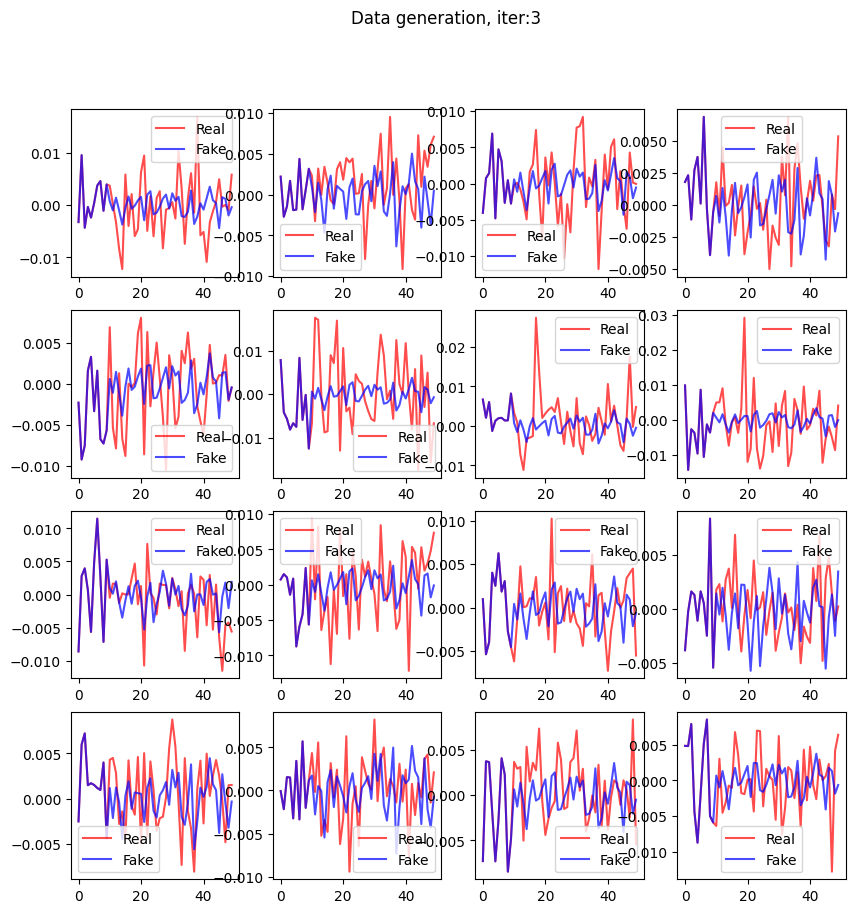

In [ ]:
show_examples(train.real_lines, train.fake_lines, size=4)

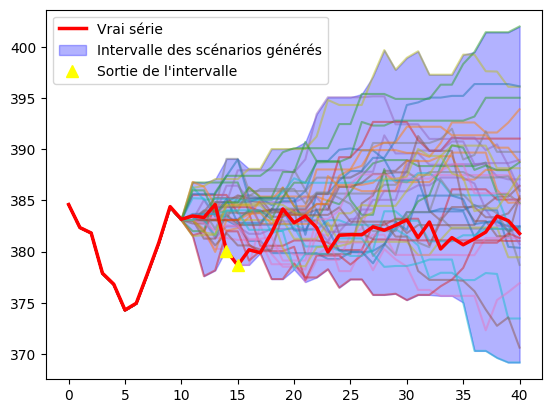

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 2 
 --------------------------------------------------


In [123]:
generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 3,num =40)

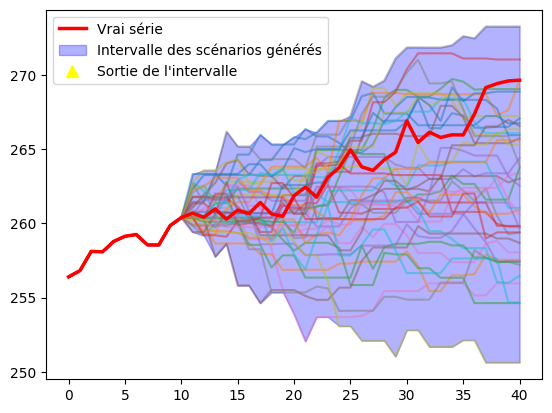

-------------------------------------------------- 
Nombre de fois que la vraie série est sortie de l'intervalle :
 0 
 --------------------------------------------------


In [124]:
start = 200
generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 2,num = 40)

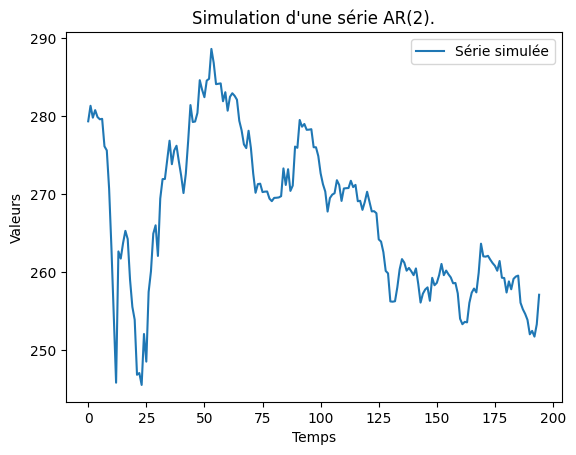

In [ ]:
simple_plot(true_y[2300:])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.021170
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.428944
[t-SNE] KL divergence after 300 iterations: 0.291691


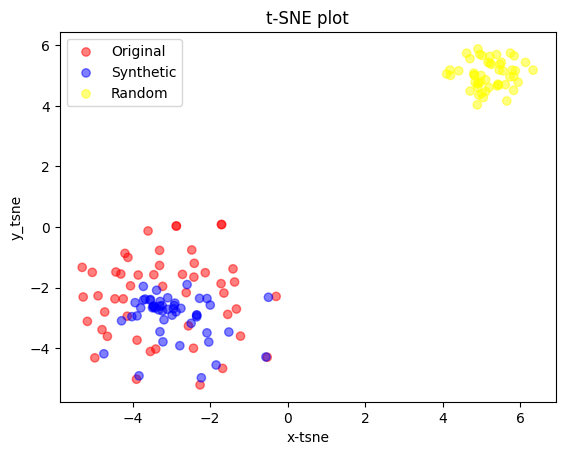

In [ ]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=50, conditional= train.conditional, use_cuda=True, data = train.data)
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=True)

In [ ]:
num = 1000
real_mean = []
fake_mean = []
for i in trange(num):
    real, fakes = train.data.get_samples(G=train.G, latent_dim=train.latent_dim, batch_size=train.batch_size, ts_dim=train.ts_dim,conditional=train.conditional,data= train.y, use_cuda=train.use_cuda)
    real_array = real.cpu().detach().numpy().reshape(256,50)
    fake_array = fakes.cpu().detach().numpy().reshape(256,50)/3
    fake_mean.append(np.mean(fake_array))
    real_mean.append(np.mean(real_array))


100%|██████████| 1000/1000 [00:13<00:00, 75.19it/s]


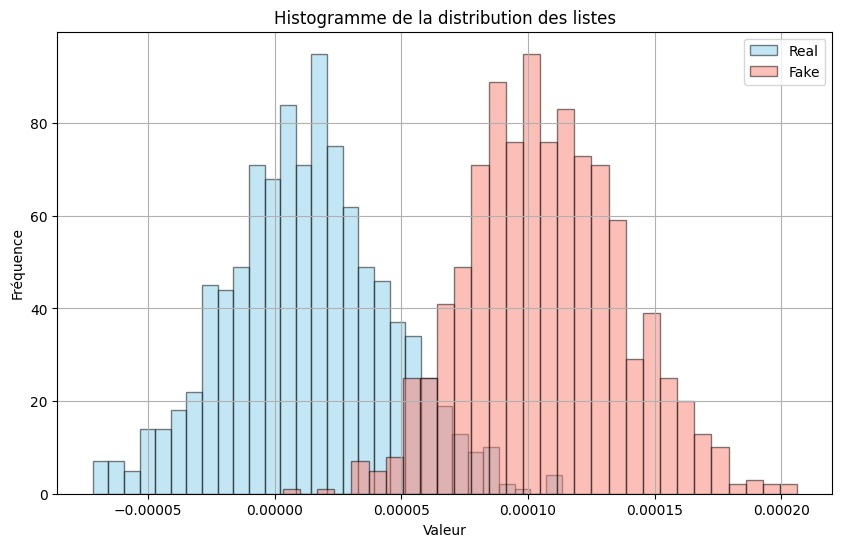

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(real_mean, bins=30, color='skyblue', alpha=0.5, label='Real', edgecolor='black')
plt.hist(fake_mean, bins=30, color='salmon', alpha=0.5, label='Fake', edgecolor='black')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.title('Histogramme de la distribution des listes')
plt.legend()
plt.grid(True)
plt.show()

Entrainement de plusieurs series à la fois

In [ ]:
filtered_df = pd.DataFrame()

for actif in df['ASSETNAME'].unique():
    actif_df = df[df['ASSETNAME']==actif]['PRICE']
    if len(actif_df) > 2500:
        filtered_df[actif] = actif_df.reset_index(drop=True)

filtered_df = filtered_df.dropna()

print(filtered_df)

      Global Property USD Unhedged  Global Government Bond USD Hedged  \
0                       889.640000                           332.1846   
1                       916.070000                           334.4977   
2                      1006.430000                           336.1632   
3                       983.720000                           340.3984   
4                      1005.670000                           342.6106   
...                            ...                                ...   
2498                   5298.985653                           844.1457   
2499                   5245.844687                           846.3291   
2500                   5194.760579                           843.0870   
2501                   5162.396117                           844.5036   
2502                   5124.047938                           850.3725   

      Europe ex UK Equity - USD Unhedged  UK Equity - USD Unhedged  \
0                            3343.142000             

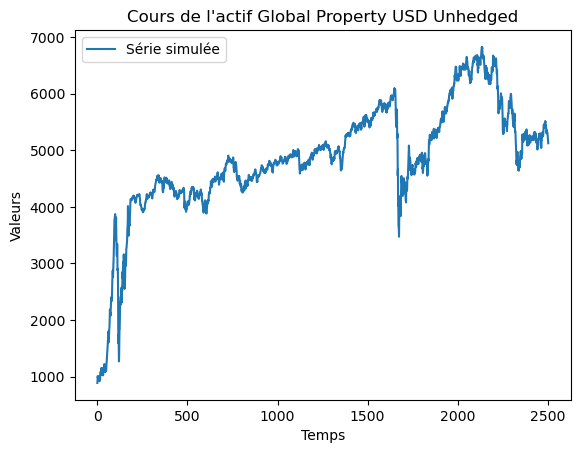

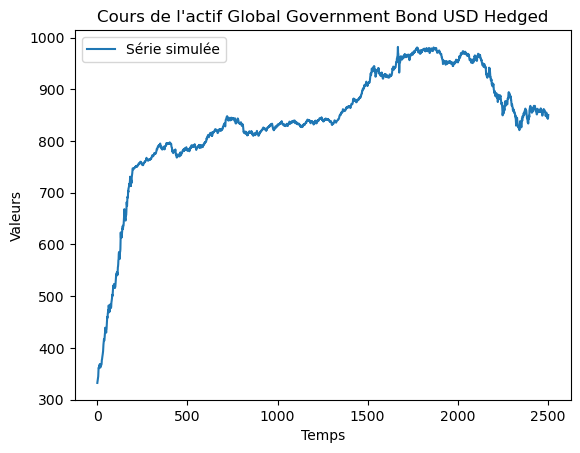

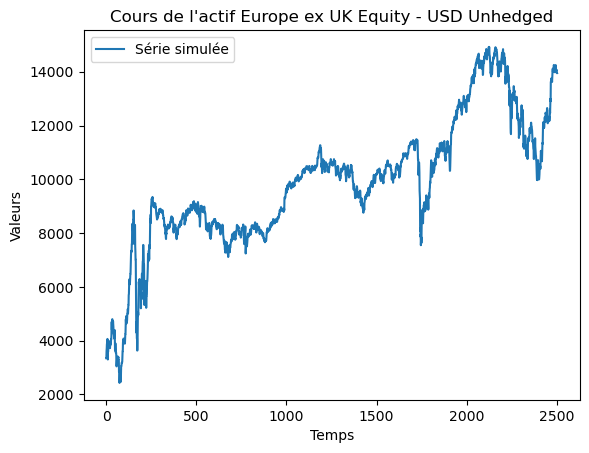

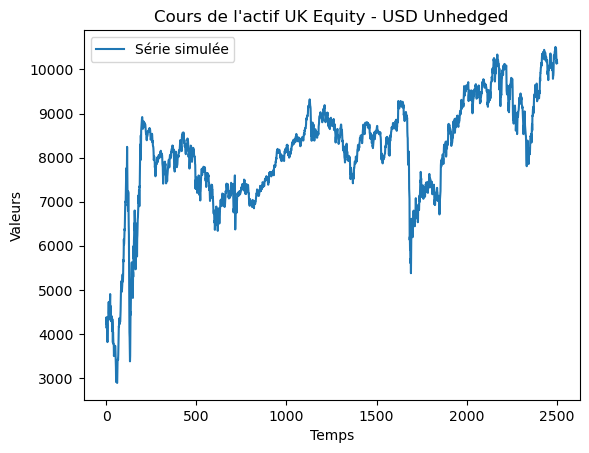

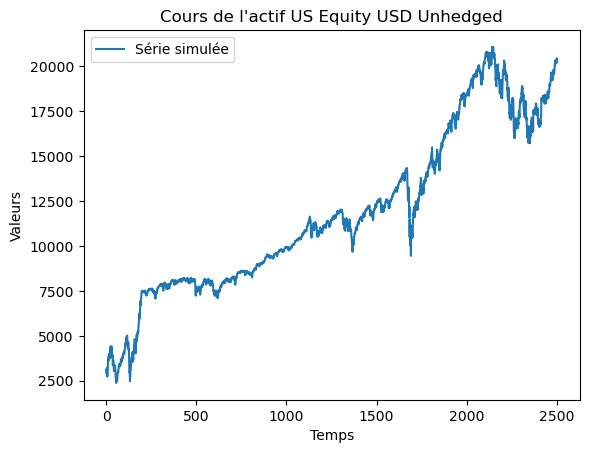

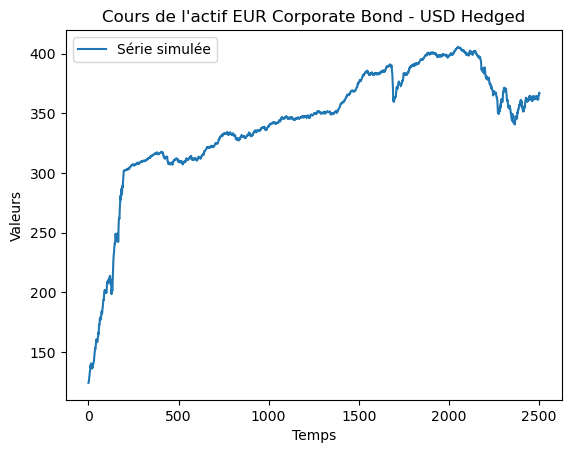

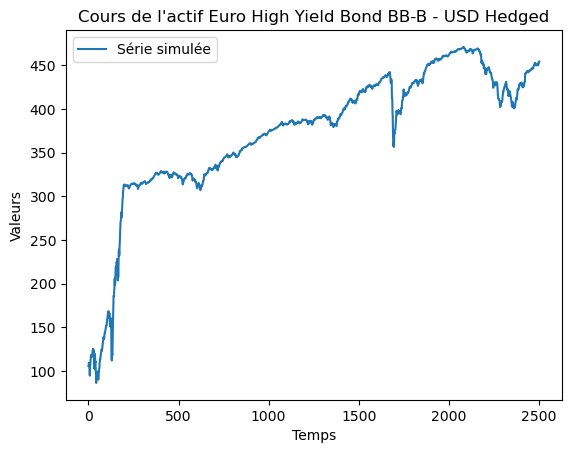

In [ ]:
for column in filtered_df.columns:
    simple_plot(filtered_df[column], f"Cours de l'actif {column}")

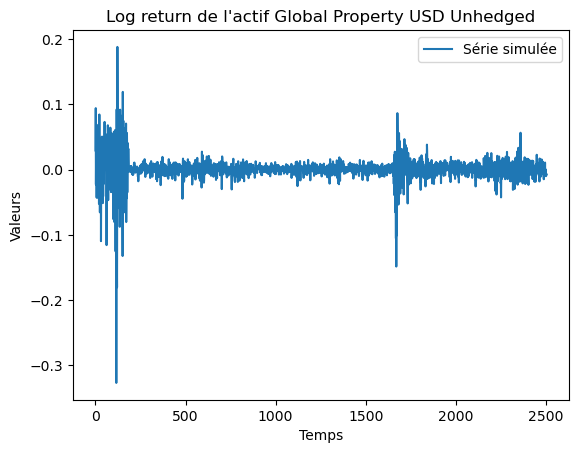

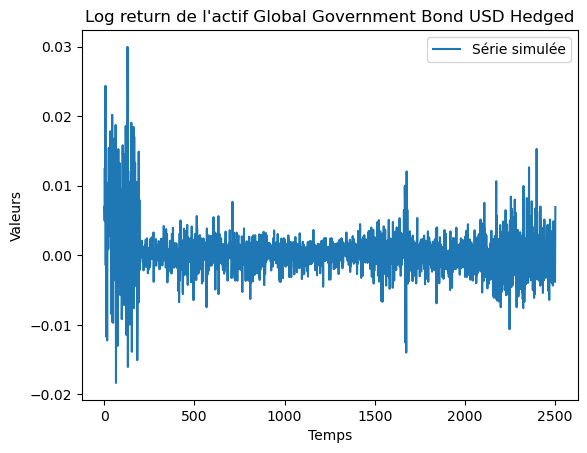

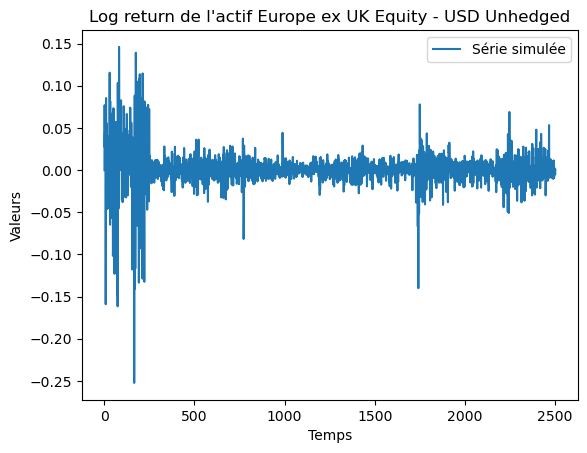

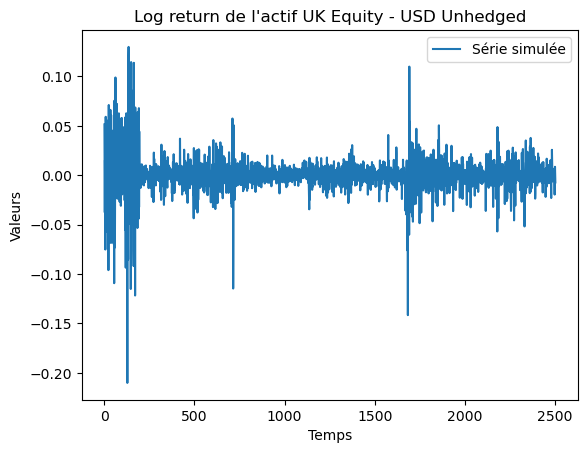

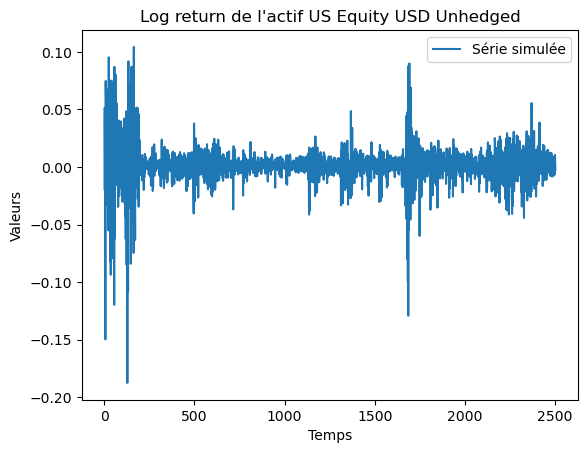

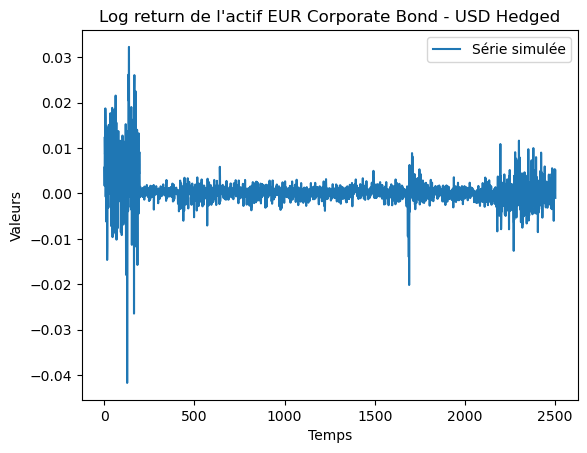

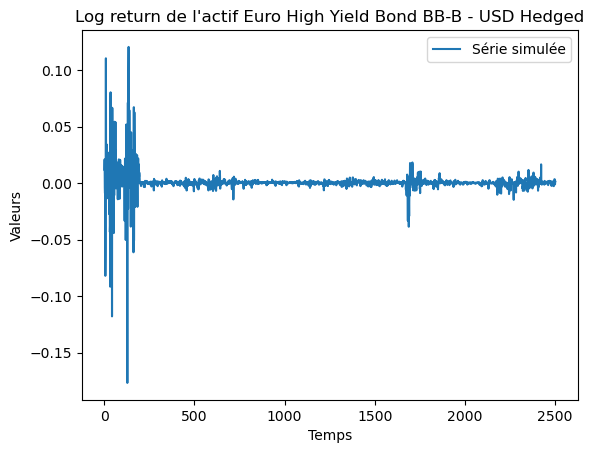

In [ ]:
for column in filtered_df.columns:
    simple_plot(np.log(filtered_df[column]/filtered_df[column].shift(1))[1:], f"Log return de l'actif {column}")

In [ ]:
for column in filtered_df.columns:
    y = filtered_df[column].values
    print(y)

[ 889.64        916.07       1006.43       ... 5194.76057876 5162.39611733
 5124.0479381 ]
[332.1846 334.4977 336.1632 ... 843.087  844.5036 850.3725]
[ 3343.142     3343.142     3610.708    ... 14017.85204  13944.970576
 13947.545476]
[ 4151.048     4370.304     4379.814    ... 10219.162289 10220.375606
 10146.419448]
[ 2946.083     3099.36      3136.193    ... 20409.804858 20451.176585
 20394.436958]
[124.022 124.73  124.94  ... 365.501 367.427 367.067]
[105.701 106.964 109.238 ... 453.376 453.748 454.355]


In [ ]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 0 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 2000
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)
# Concatenate all columns into a single numpy array
y = np.concatenate([filtered_df[column].values for column in filtered_df.columns])

# Train a single GAN model on the concatenated data
train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda)
train.train_model(epochs=epochs)

False


  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\tahah\anaconda3\envs\gan_basique\lib\site-packages\torch\optim\lr_scheduler.py:1333: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  1%|          | 19/2000 [01:09<2:01:35,  3.68s/it]